# Multitask GP Regression
An example of multi-outputs GP regression with multi-inputs using GPytorch

In [1]:
import numpy as np
import pandas as pd
import torch
import gpytorch as gpt

from matplotlib import pyplot as plt
%matplotlib inline

print("torch:", torch.__version__, " gpytorch:", gpt.__version__)

torch: 1.10.2+cu102  gpytorch: 1.6.0


### Set up data

In [2]:
meuse_df = pd.read_csv("../data/meuse.csv")
print(meuse_df.shape)
targets = ["cadmium", "copper", "lead", "zinc"]
features = ["dist", "x", "y"]

meuse_df[targets] = meuse_df[targets] / meuse_df[targets].mean() # Normalise data

(155, 14)


In [3]:
df_x = torch.tensor(meuse_df[features].values, dtype=torch.float32)
df_y = torch.tensor(meuse_df[targets].values, dtype=torch.float32)
df_x.shape, df_y.shape

(torch.Size([155, 3]), torch.Size([155, 4]))

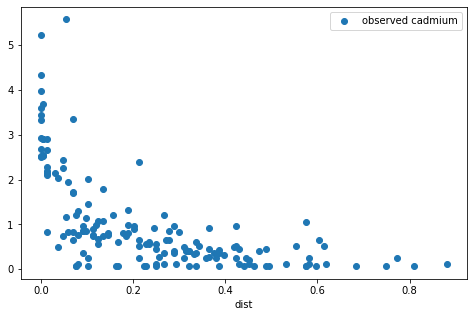

In [4]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.scatter(df_x.numpy()[:,0], df_y.numpy()[:,0])
plt.legend(["observed cadmium"]);
plt.xlabel("dist")
plt.show();

### Define a multitask model

In [5]:
class MultitaskGPModel(gpt.models.ExactGP):
    def __init__(self, x, y, likelihood):
        super(MultitaskGPModel, self).__init__(x, y, likelihood)
        self.mean_module = gpt.means.MultitaskMean(
            gpt.means.ConstantMean(), num_tasks=4
        )
        self.covar_module = gpt.kernels.MultitaskKernel(
            gpt.kernels.RBFKernel() + gpt.kernels.MaternKernel(), num_tasks=4, rank=3
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpt.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [6]:
likelihood = gpt.likelihoods.MultitaskGaussianLikelihood(num_tasks=4)
model = MultitaskGPModel(df_x, df_y, likelihood)

### Train the model

In [7]:
training_iters = 30

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
# Loss for the marginal log likelihood
mll = gpt.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iters):
    optimizer.zero_grad()
    output = model(df_x)
    loss = -mll(output, torch.reshape(df_y, (-1,)))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iters, loss.item()))
    optimizer.step()

/home/danph/Repos/win_ssd/oss/gp_experiments/.venv/lib/python3.8/site-packages/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


Iter 1/30 - Loss: 2.058
Iter 2/30 - Loss: 1.991
Iter 3/30 - Loss: 1.927
Iter 4/30 - Loss: 1.867
Iter 5/30 - Loss: 1.809
Iter 6/30 - Loss: 1.754
Iter 7/30 - Loss: 1.703
Iter 8/30 - Loss: 1.654
Iter 9/30 - Loss: 1.604
Iter 10/30 - Loss: 1.551
Iter 11/30 - Loss: 1.493
Iter 12/30 - Loss: 1.431
Iter 13/30 - Loss: 1.366
Iter 14/30 - Loss: 1.305
Iter 15/30 - Loss: 1.254
Iter 16/30 - Loss: 1.215
Iter 17/30 - Loss: 1.182
Iter 18/30 - Loss: 1.148
Iter 19/30 - Loss: 1.111
Iter 20/30 - Loss: 1.071
Iter 21/30 - Loss: 1.032
Iter 22/30 - Loss: 0.999
Iter 23/30 - Loss: 0.969
Iter 24/30 - Loss: 0.935
Iter 25/30 - Loss: 0.893
Iter 26/30 - Loss: 0.853
Iter 27/30 - Loss: 0.823
Iter 28/30 - Loss: 0.802
Iter 29/30 - Loss: 0.777
Iter 30/30 - Loss: 0.747


### Make predictions with the model

In [8]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpt.settings.fast_pred_var():
    predictions = likelihood(model(df_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

/home/danph/Repos/win_ssd/oss/gp_experiments/.venv/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


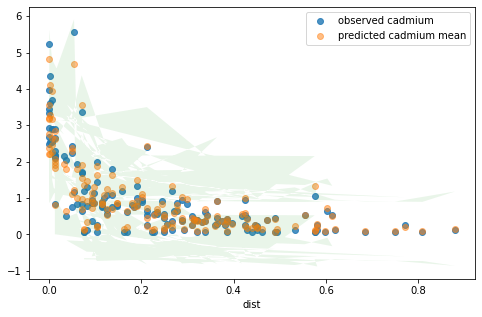

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.scatter(df_x.numpy()[:,0], df_y.numpy()[:,0], alpha=0.8)
ax.scatter(df_x.numpy()[:,0], mean.numpy()[:,0], alpha=0.5)
ax.fill_between(df_x.numpy()[:,0], lower.numpy()[:, 0], upper.numpy()[:, 0], alpha=0.1)

plt.legend(["observed cadmium", "predicted cadmium mean"])
plt.xlabel("dist")
plt.show();

References: 
- https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html
- https://nextjournal.com/essicolo/spatial-prediction-of-soil-pollutants-with-multi-output-gaussian-processes?version=latest